In [1]:
include("src/SpinonStructure.jl")
include("src/BZMath.jl")
# include("PyrochloreGeometry.jl")
# import .PyrochloreGeometry as geom
using .BZmath
using .SpinonStructure
using LinearAlgebra
using StaticArrays
using BenchmarkTools
using Plots

In [3]:
using Rotations
using LinearAlgebra

function M_analytic_0flux(Jpm, k)
    n = [1,0,0]
    n ./= norm(n)
    
    # R = AngleAxis(π/8, n...)
    R = AngleAxis(0, n...)
    return Jpm/2*( cos( k'*R*[0,4,4]) + cos( k'*R*[4,0,4]) + cos( k'*R*[4,4,0]) + cos( k'*R*[0,4,-4]) + cos( k'*R*[4,0,-4]) + cos( k'*R*[4,-4,0]) )
end


M_analytic_0flux (generic function with 1 method)

In [4]:
high_symmetry_points = Dict(
    "\\Gamma"=> [0.,0.,0.],
    "X"=> [1.,0.,0.],
    "W"=> [1.,0.5,0.],
    "K"=> [0.75,0.75,0.],
    "L"=> [0.5,0.5,0.5],
    "U"=> [1.0, 0.25,0.25]
)

high_symmetry_points_2 = Dict(
    "\\Gamma"=> [0.,0.,0.],
    "X"=> [1.,0.,0.],
    "W"=> [1.,0.5,0.],
    "K"=> [0.75,0.75,0.],
    "L"=> [0.5,0.5,0.5],
    "U"=> [1.0, 0.25,0.25]
)

path = generate_path(high_symmetry_points, split("\\Gamma X W K \\Gamma L U W"), points_per_unit=30, K_units=2π/8);

In [5]:
sim_0 = SpinonStructure.SimulationParameters("0flux", A=zeros(4,4), Jpm=-0.046, B=zeros(3), nsample=10000, kappa=2.0)
sim_0.λ

0.1410626799125433

In [6]:
lambda_g = SpinonStructure.calc_lambda( k-> M_analytic_0flux(sim_0.Jpm, k),10000,2.)
    

0.1413373994955694

In [7]:
using Printf

f1 = k-> spinon_dispersion(k, sim_0 )[1]


function plot_spinons(f;color=:black)
    E = reduce(vcat, map(f, path.K )')

    plot!(path.t,E,legend=false,color=color,lw=0.5)
    xticks!(path.ticks_t, path.ticks_label)
    ylims!(0.,maximum(E))

    # bstr = @sprintf("[%.3f,%.3f,%.3f]",sim.B[1],sim.B[2],sim.B[3])  
    # if norm( abs.(sim.B/norm(sim.B))- [1,1,1]/√3) < 1e-8
    #     bstr = @sprintf("%.3f [1,1,1]/\\sqrt{3}", norm(sim.B) )
    # elseif norm( abs.(sim.B/norm(sim.B))- [1,1,0]/√2) < 1e-8
    #     bstr = @sprintf("%.3f [1,1,0]/\\sqrt{2}", norm(sim.B))
    # end
    # title!(@sprintf("\$J_\\pm=%.3fJ_{yy}, B=%s J_{yy}\$",sim.Jpm,bstr)  )
    # savefig(@sprintf("figures/dispersion_%s?J_pm=%.3f?B=[%.3f,%.3f,%.3f].pdf",sim.name,sim.Jpm,sim.B[1],sim.B[2],sim.B[3])  )
    
    return plot!()
end

plot_spinons (generic function with 1 method)

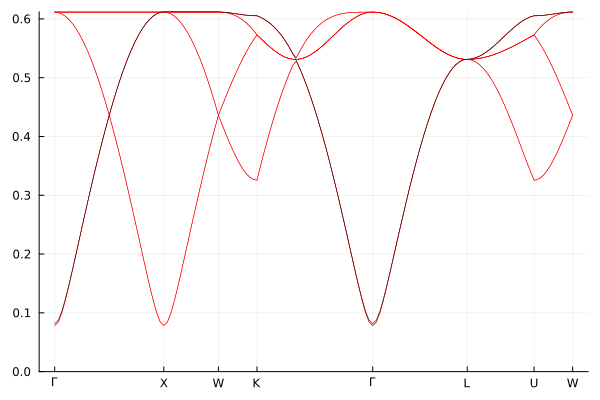

In [8]:
plot()

plot_spinons(f1,color=:red)
plot_spinons( k-> sqrt(2)*sqrt(M_analytic_0flux(sim_0.Jpm, k) + lambda_g)  )
# plot_spinons( k-> sqrt(2)*sqrt(M_analytic_0flux(sim_0.Jpm, k+[2π/8,0,0]) + lambda_g)  )
# plot_spinons( k-> sqrt(2)*sqrt(M_analytic_0flux(sim_0.Jpm, k+[0,2π/8,0]) + lambda_g)  )
# plot_spinons( k-> sqrt(2)*sqrt(M_analytic_0flux(sim_0.Jpm, k+[0,0,2π/8]) + lambda_g)  )

In [9]:
function spinon_dispersion_analytic(k, sim)
    ϵ = M_analytic_0flux(sim.Jpm, k)
    return sqrt( 2 .*(ϵ + sim.λ))
end

spinon_dispersion_analytic (generic function with 1 method)

In [26]:
# define static convenience types

const Vec3 = geom.Vec3;
const Vec3_F64 = geom.Vec3_F64;
################################################################################
### Calculating the spectral weight
################################################################################

"""
	specweight_at(q, Δ, sim)
	-> E, S

Calculates the contribution of kspace points(q ± Δ) to the Δ integral in 
`spectral_weight`. Let there be N tetrahedra in `sim`, i.e. N bands.
Returns: 
`E`, an (N, N) matrix of e1 + e2 energies corresponding to Dirac delta peaks
`S`, an (N, N) matrix of spectral weights giving the heights of these peaks
"""
function specweight_at(q::Vec3_F64, p::Vec3_F64, sim::SimulationParameters)
    p1 = p
    p2 = q-p
    
    E1 = spinon_dispersion_analytic( p1, sim)
    E2 = spinon_dispersion_analytic( p2, sim)
    
    S = 0
    for mu=1:4, nu=1:4
        # for (jA, rA) in enumerate(sim.lat.A_sites), (jpA, rpA) in enumerate(sim.lat.A_sites)
        #     jB = geom.tetra_idx(sim.lat, rA + geom.pyro[mu])
        #     jpB = geom.tetra_idx(sim.lat, rpA + geom.pyro[nu])

        # the "l" bit
        x1 = 1 / (2*E1) 
        # the "l'" bit
        x2 = 1 / (2*E2) 
            
        S += x1*x2*exp(-2im*(p-q/2)'*(geom.pyro[mu]-geom.pyro[nu]))
        # end
    end
    E = E1 + E2
    return E, S
end

specweight_at

In [11]:


"""
    spectral_weight(q, Egrid, sim::SimulationParameters, 
						 nsample::Int=1000, grid_density::Int=1000
						 )

Calculates the spectral weight at point `q`.

This performs a Monte Carlo integral over the Brillouin zone.
`grid_density` sets the number of points in one dimension of the Brillouin zone.
`nsample` is the number of these k-points to sample.

"""
function spectral_weight(q::Vec3_F64, Egrid::Vector{Float64}, sim::SimulationParameters, 
						 integral_params::IntegrationParameters
						 )
    # cursed Monte Carlo integration
    num_flavours = div(length(sim.A),2)
    res = 0

    grid_density=integral_params.BZ_grid_density

    # p_vals = (@SMatrix rand((-grid_density:grid_density),integral_params.n_K_samples,3))/grid_density  * π / 8
    
    # p_vals_2 = (1 .- 2 .*(@SMatrix rand(integral_params.n_K_samples,3)))*π/8
    # p_vals = p_vals_1 .- p_vals_2
    
    Sqω = zeros(ComplexF64,size(Egrid))
    # perform an MC integral
    # dE = (Egrid[2]-Egrid[1])*broaden_factor

    bounds = [Inf, -Inf]
    
    for _ in 1:integral_params.n_K_samples
        p =  (1 .- 2 .*(@SVector rand(3)))*100*π/8
        E, S = specweight_at(q, p, sim)
        Sqω += map(
            e-> S*Lorentzian(e - E, integral_params.broadening_dE),
                Egrid)
        bounds[1] = min(bounds[1], E ) 
        bounds[2] = max(bounds[2], E )
    end
    return Sqω, bounds
end

spectral_weight

In [12]:
@inline function Lorentzian(x, Γ)
    local N = 1/π
    Γ /= 2
    return N*1. * Γ/(x^2 + Γ^2)
end

Lorentzian (generic function with 1 method)

In [13]:
ip_GL = IntegrationParameters(n_K_samples=8,BZ_grid_density=50,broadening_dE=0.2)

ip_fast = IntegrationParameters(n_K_samples=100,BZ_grid_density=50,broadening_dE=0.05)
ip_slow = IntegrationParameters(n_K_samples=1000,BZ_grid_density=500,broadening_dE=0.05)
ip_very_slow = IntegrationParameters(n_K_samples=10000,BZ_grid_density=500,broadening_dE=0.05)
ip_ultra_slow = IntegrationParameters(n_K_samples=100000,BZ_grid_density=500,broadening_dE=0.02)

IntegrationParameters(100000, 500, 0.02)

In [27]:
using ProgressMeter

sim = sim_0
ip = ip_very_slow

Egrid = collect(range(0,1.3,100))
num_K = length(path.K)

bounds = zeros(Float64, num_K, 2)

p = Progress(num_K)

S = zeros(ComplexF64, num_K, length(Egrid))
for I = 1:num_K
    k = path.K[I]*0.5
    q = SVector(k[1], k[2], k[3])
    S[I, :], bounds[I,:] = spectral_weight(q, Egrid, sim, ip)
    # S[I, :], bounds[I,:] = spectral_density_of_states_GL(q, Egrid, sim, ip)
    next!(p)
end

finish!(p)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


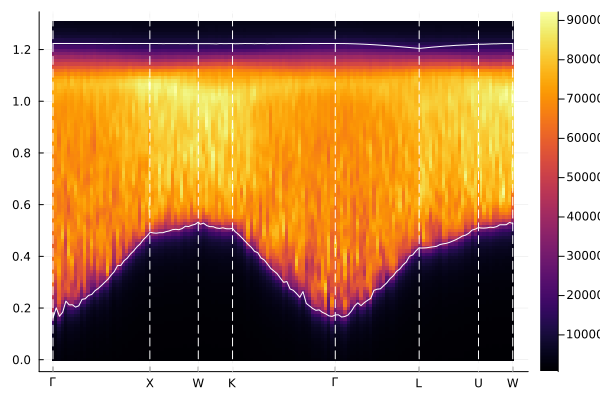

In [28]:
heatmap(path.t, Egrid, real(S)')#,clims=(10000,100000))
plot!(path.t, bounds,linecolor=:white)
plot!(legend=nothing)
vline!(path.ticks_t, linecolor=:white, linestyle=:dash)
xticks!(path.ticks_t, path.ticks_label)